In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers

from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime

2021-07-21 12:36:42.907601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-21 12:36:42.907638: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# uncomment the line with the data set you wanna use

# data = pd.read_csv('data/train.csv', index_col='TransactionID')  # (this is the dataset which yeilded a much higher scores)
# data = pd.read_csv('data/mini_data.csv', index_col='TransactionID')
data.drop(['TransactionDT'], axis=1, inplace=True)
data.head()


,Unnamed: 0,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0,0,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,1,0,15.000,H,2803,100.0,150.0,visa,226.0,debit,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,2,0,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,3,0,16.495,C,4461,375.0,185.0,mastercard,224.0,debit,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,4,0,30.000,H,1790,555.0,150.0,visa,226.0,debit,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


#### DATA CLEANING & PREPROCESSING

In [3]:
# data cleaning
def get_all_categorical_features():
    features = [
        'ProductCD',
        'addr1',
        'addr2',
        'P_emaildomain',
        'R_emaildomain',
        'DeviceType',
        'DeviceInfo',
    ]
    for i in range(1, 7):
        features.append(f'card{i}')
    for i in range(1, 10):
        features.append(f'M{i}')
    for i in range(12, 39):
        features.append(f'id_{i}')
    return features


def correcting_data_types(data, features):
    for i in data:
        if i in features:
            data[i] = data[i].astype("string")
        else:
            data[i] = pd.to_numeric(data[i])
    return data


def fill_missing_values(data):
    for column in data:
        if data[column].dtype.name == 'string':
            data[column].fillna('not available', inplace=True)
        else:
            mean = data[column].mean()
            if str(mean) == 'nan':
                data[column].fillna(0, inplace=True)
            else:
                data[column].fillna(mean, inplace=True)
    return data


def label_encode_categorical_features(data, features):
    encoder = preprocessing.LabelEncoder()
    for category in features:
        data[category] = encoder.fit_transform(data[category])
    return data


def cleaning_data(data, categorical_features):
    data = correcting_data_types(data=data, features=categorical_features)
    data = fill_missing_values(data=data)
    data = label_encode_categorical_features(data, categorical_features)
    na_cols = [col for col in data.columns if data[col].isna(
    ).unique()[0] == True and len(data[col].isna().unique()) == 1]
    data = data.drop(na_cols, axis=1)
    return data


dataset = cleaning_data(data, get_all_categorical_features())


#### PREPROCESSING - UNDER SAMPLING AND DATA SCALING

In [4]:
rus = RandomUnderSampler()
std = RobustScaler()

x_sampled, y_sampled = rus.fit_resample(dataset.drop(['isFraud'], axis=1), dataset['isFraud'])
x_std = std.fit_transform(x_sampled) 

x_train, x_test, y_train, y_test = train_test_split(x_std, y_sampled, shuffle=True, test_size=.3)

del x_sampled
del y_sampled

### Model Design and Architecture

In [5]:
# BASELINE MODEL ( model to beat )
forest = RandomForestClassifier(bootstrap=True,
                                max_depth=70,
                                max_features='auto',
                                min_samples_leaf=4,
                                min_samples_split=10,
                                n_estimators=400)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

print(f'F1 SCORE: {f1_score(y_test, y_pred)}')
print(f'ACCURACY SCORE: {accuracy_score(y_test, y_pred)}')
print(f'PRECISION SCORE: {precision_score(y_test, y_pred)}')
print(f'RECALL SCORE: {recall_score(y_test, y_pred)}')


F1 SCORE: 0.8777777777777778
ACCURACY SCORE: 0.8777777777777778
PRECISION SCORE: 0.8936651583710408
RECALL SCORE: 0.8624454148471615


#### DEFINING AND TESTING THE NEURAL NETWORK

2021-07-21 12:37:20.517350: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-21 12:37:20.703497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-21 12:37:20.704395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GT 540M computeCapability: 2.1
coreClock: 1.344GHz coreCount: 2 deviceMemorySize: 964.50MiB deviceMemoryBandwidth: 26.82GiB/s
2021-07-21 12:37:20.704657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-21 12:37:20.704792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libc

Epoch 1/10
53/53 [==============================] - 5s 14ms/step - loss: 0.0979 - accuracy: 0.7110 - val_loss: 0.0987 - val_accuracy: 0.7500
Epoch 2/10
53/53 [==============================] - 0s 7ms/step - loss: 0.0800 - accuracy: 0.7688 - val_loss: 0.0882 - val_accuracy: 0.7881
Epoch 3/10
53/53 [==============================] - 0s 7ms/step - loss: 0.0788 - accuracy: 0.7592 - val_loss: 0.0811 - val_accuracy: 0.7762
Epoch 4/10
53/53 [==============================] - 0s 8ms/step - loss: 0.0738 - accuracy: 0.7729 - val_loss: 0.0804 - val_accuracy: 0.7452
Epoch 5/10
53/53 [==============================] - 0s 7ms/step - loss: 0.0723 - accuracy: 0.7867 - val_loss: 0.0792 - val_accuracy: 0.7357
Epoch 6/10
53/53 [==============================] - 0s 6ms/step - loss: 0.0697 - accuracy: 0.7896 - val_loss: 0.0784 - val_accuracy: 0.7857
Epoch 7/10
53/53 [==============================] - 0s 8ms/step - loss: 0.0654 - accuracy: 0.8081 - val_loss: 0.0758 - val_accuracy: 0.7619
Epoch 8/10
53/53 [=

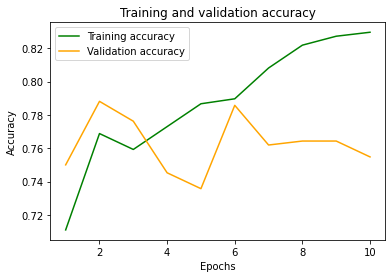

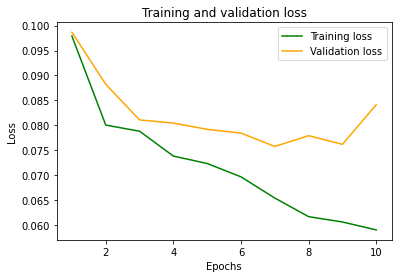

In [6]:
l1 = 0.0000001
l2 = 0.0000001
dropout = 0.05
epochs = 10

model = Sequential()
model.add(layers.Dense(100, activation=activations.linear,
                        input_shape=x_train.shape[1:], activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
model.add(layers.Activation(activation=activations.relu))

model.add(BatchNormalization())
model.add(layers.Dropout(dropout))
model.add(layers.Dense(100, activation=activations.linear,
                        activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
model.add(layers.Activation(activation=activations.relu))

model.add(BatchNormalization())
model.add(layers.Dropout(dropout))
model.add(layers.Dense(128, activation=activations.linear,activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
model.add(layers.Activation(activation=activations.relu))

model.add(BatchNormalization())
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64, activation=activations.linear, activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
model.add(layers.Activation(activation=activations.relu))

model.add(BatchNormalization())
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1, activation=activations.sigmoid))

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.logcosh, metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='auto', baseline=None)
history = model.fit(x=x_train, y=y_train, epochs=epochs,validation_split=.2, callbacks=[es])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epo_range = range(1, len(acc)+1)

plt.plot(epo_range, acc, 'green', label='Training accuracy')
plt.plot(epo_range, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

epo_range = range(1, len(acc)+1)

plt.plot(epo_range, loss, 'green', label='Training loss')
plt.plot(epo_range, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# TESTING THE NEURAL NETWORK
y_pred = model.predict(x_test)

print(f'F1 SCORE: {f1_score(y_test, [round(p[0]) for p in  y_pred])}')
print(f'ACCURACCORE: {accuracy_score(y_test, [round(p[0]) for p in  y_pred])}')
print(f'PRECISION SCORE: {precision_score(y_test, [round(p[0]) for p in  y_pred])}')
print(f'RECALL SCORE: {recall_score(y_test, [round(p[0]) for p in  y_pred])}')


F1 SCORE: 0.7935135135135135
ACCURACCORE: 0.7877777777777778
PRECISION SCORE: 0.7858672376873662
RECALL SCORE: 0.8013100436681223


### FUNCTION TO GENERATE THE NEURAL NETWORK

In [8]:


def get_neural_network():
    l1 = 0.0000001
    l2 = 0.0000001
    dropout = 0.06
    epochs = 10

    model = Sequential()
    model.add(layers.Dense(100, activation=activations.linear,
                           input_shape=x_train.shape[1:], activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Activation(activation=activations.relu))

    model.add(BatchNormalization())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(100, activation=activations.linear,
                           activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Activation(activation=activations.relu))

    model.add(BatchNormalization())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(100, activation=activations.linear,activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Activation(activation=activations.relu))

    model.add(BatchNormalization())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(50, activation=activations.linear, activity_regularizer=regularizers.l1(l1), kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Activation(activation=activations.relu))

    model.add(BatchNormalization())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation=activations.sigmoid))

    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.logcosh, metrics=['accuracy'])

    return model


es = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience=10, verbose=0, mode='auto', baseline=None)

classifier = KerasClassifier(
    get_neural_network, epochs=10, callbacks=[es], verbose=0)
classifier._estimator_type = "classifier"


In [9]:
esti = [
    ('xgb_cls', xgb.XGBClassifier(use_label_encoder=False, learning_rate=0.1, n_estimators=300, max_depth=5, min_child_weight=1, gamma=0,
                                  subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', nthread=4, scale_pos_weight=1, eval_metric='mlogloss', seed=27)),
    ('lightgbm', lgb.LGBMClassifier(objective='binary', metric='auc',
                                    is_unbalance=True, boosting='gbdt', num_boost_round=300)),
    ('neural_net', classifier),
]

stack = StackingClassifier(
    estimators=esti, final_estimator=RandomForestClassifier())

t0 = datetime.now()
stack.fit(x_train, y_train)
t1 = datetime.now()
print(f'Time Elapsed: {t1-t0}')


/home/admin/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/home/admin/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/admin/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/home/admin/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/home/admin/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/home/admin/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
Time Elapsed: 0:01:35.433969


In [10]:
p_pred = stack.predict(x_test)

print(f'F1 SCORE: {f1_score(y_test, p_pred)}')
print(f'ACCURACY SCORE: {accuracy_score(y_test, p_pred)}')
print(f'PRECISION SCORE: {precision_score(y_test, p_pred)}')
print(f'RECALL SCORE: {recall_score(y_test, p_pred)}')


F1 SCORE: 0.8881431767337808
ACCURACY SCORE: 0.8888888888888888
PRECISION SCORE: 0.9105504587155964
RECALL SCORE: 0.8668122270742358


In [11]:
yp = pd.Series(p_pred)
print('<------[ TEST ]------>')
print(f'Non-Fraud Count: {len(y_test[y_test == 0])}')
print(f'Fraud Count: {len(y_test[y_test == 1])}')
print('<----[ PREDICTION ]--->')
print(f'Non-Fraud Count: {len(yp[yp == 0])}')
print(f'Fraud Count: {len(yp[yp == 1])}')
print('<-------[ END ]------->')


<------[ TEST ]------>
Non-Fraud Count: 442
Fraud Count: 458
<----[ PREDICTION ]--->
Non-Fraud Count: 464
Fraud Count: 436
<-------[ END ]------->


In [52]:
import pickle
import dill
import cloudpickle
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Model


def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function


def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__


# Run the function
make_keras_picklable()

with open('mod/stack_model.pkl', 'wb') as file:
    cloudpickle.dump(stack, file)


In [2]:
import dill


def open_test_data():
    return open('mod/stack_model.pkl', 'rb')


with open_test_data() as f:
    mo = dill.load(f)


2021-07-21 09:24:06.942381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-21 09:24:06.942451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-07-21 09:24:24.237585: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-21 09:24:24.244644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-21 09:24:24.245666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GT 540M computeCapability: 2.1
coreClock: 1.344GHz coreCount: 2 deviceMemorySize: 964.50MiB devi

In [7]:
o_pred = mo.predict(x_test)

print(f'F1 SCORE: {f1_score(y_test, o_pred)}')
print(f'ACCURACY SCORE: {accuracy_score(y_test, o_pred)}')
print(f'PRECISION SCORE: {precision_score(y_test, o_pred)}')
print(f'RECALL SCORE: {recall_score(y_test, o_pred)}')


2021-07-21 09:25:49.515775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-21 09:25:49.907342: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2793490000 Hz


F1 SCORE: 0.939812750780205
ACCURACY SCORE: 0.9403622441466647
PRECISION SCORE: 0.9368888888888889
RECALL SCORE: 0.9427549194991055


##### MISC STUFF

In [ ]:
# es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, verbose=0, mode='auto', baseline=None)

# classifier = KerasClassifier(get_neural_network, epochs=10, callbacks=[es], verbose=0)
# classifier._estimator_type = "classifier"

# stack = StackingClassifier(
#     estimators=[
#         ('xgb_cls', xgb.XGBClassifier(use_label_encoder=False, learning_rate =0.1, n_estimators=300, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, eval_metric='mlogloss', seed=27)),
#         ('lightgbm', lgb.LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, boosting='gbdt', num_boost_round=300)),
#         ('neural_net', classifier),
#     ],
#     final_estimator=RandomForestClassifier()
# )


In [8]:
data.head()


,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0,50.000,1,5786,399,39,2,2,1,178,...,124,3,164,3,1,0,1,1,1,954
2987008,0,15.000,1,4968,0,39,4,97,2,133,...,98,3,48,2,1,0,0,1,1,1727
2987010,0,75.887,0,3487,243,10,2,28,1,255,...,44,4,260,4,0,0,1,1,0,1598
2987011,0,16.495,0,5766,266,66,2,95,2,255,...,44,4,260,4,0,0,1,1,0,1742
2987016,0,30.000,1,4247,437,39,4,97,2,39,...,44,2,40,3,1,0,1,1,0,723


In [24]:
from os import getcwd
test_f = data[data['isFraud'] == 1][5:]
test_n = data[data['isFraud'] == 0][5:]


#


In [25]:
test = pd.concat([test_f, test_n])
test
# test.to_csv(f'{getcwd()}/data/test/single_pred_test.csv')


,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987405,1,90.570,0,5787,385,66,2,92,1,255,...,98,4,260,4,0,0,0,1,1,1742
2987630,1,12.326,0,6430,298,66,2,95,2,255,...,80,4,260,4,0,0,0,1,0,1598
2987683,1,124.344,0,6430,298,66,2,95,2,255,...,80,4,260,4,0,0,1,1,0,1598
2987779,1,10.000,3,7235,255,35,2,55,2,190,...,62,3,4,3,1,0,1,1,1,471
2987780,1,10.000,3,7869,251,39,2,99,2,190,...,62,3,4,3,1,0,1,1,1,471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577509,0,28.527,0,3296,100,66,4,32,2,255,...,57,4,260,4,0,0,1,0,1,1273
3577521,0,48.877,0,1104,198,4,2,95,2,255,...,57,4,260,4,0,0,1,0,1,276
3577529,0,73.838,0,6080,437,66,2,31,1,255,...,54,4,260,4,0,0,1,0,1,748


In [18]:
train = data[7000:]
train.to_csv('data/train/model_train.csv')
